# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

The project folder has the following structure:

* In the main directory you have this notebook, `cnn_from_scratch.ipynb`, that contains the instruction and some questions you will have to answer. Follow this notebook and complete the required sections in order.

* In the `src/` directory you have several source files. As instructed in this notebook, you will open and complete those files, then come back to this notebook to execute some tests that will verify what you have done. While these tests don't guarantee that your work is bug-free, they will help you finding the most obvious problems so you will be able to proceed to the next step with confidence.

* Sometimes you will need to restart the notebook. If you do so, remember to execute also the cells containing the code you have already completed starting from the top, before you move on.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust your intuition.  And, of course, have fun!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

Important! After you have ran pip install, please restart the kernel using the **Kernel** menu 

In [2]:
# Install requirements
# !pip install -r requirements.txt | grep -v "already satisfied"
# !pip install torch torchvision
# !pip install livelossplot
# !pip install torch
# !pip install pytest

In [3]:
import shutil
import os
import multiprocessing
import torch
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel, ResidualBlock
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.helpers import compute_mean_and_std, plot_confusion_matrix
from src.predictor import Predictor, predictor_test
import warnings

In [4]:
from src.helpers import setup_env

import torch

# Check for GPU availability and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Uget_lossice:", device)

from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at least 2 Gb of space on your hard drive)
setup_env()

Uget_lossice: cuda:0
GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data

In this and the following steps we are going to complete some code, and then execute some tests to make sure the code works as intended. 

Open the file `src/data.py`. It contains a function called `get_data_loaders`. Read the function and complete all the parts marked by `YOUR CODE HERE`. Once you have finished, test that your implementation is correct by executing the following cell (see below for what to do if a test fails):

In [5]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 3.15s ========================


You should see something like:
```
src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 1.81s ========================
```
If all the tests are `PASSED`, you can move to the next section.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> **What to do if tests fail**
When a test fails, `pytest` will mark it as `FAILED` as opposed to `PASSED`, and will print a lot of useful output, including a message that should tell you what the problem is. For example, this is the output of a failed test:
> ```
>    def test_data_loaders_keys(data_loaders):
>    
>       assert set(data_loaders.keys()) == {"train", "valid", "test"}
E       AssertionError: assert {'tes', 'train', 'valid'} == {'test', 'train', 'valid'}
E         Extra items in the left set:
E         'tes'
E         Full diff:
E         - {'test', 'train', 'valid'}
E         + {'tes', 'train', 'valid'}
E         ?                          +++++++
>
> src/data.py:171: AssertionError
-------------- Captured stdout setup ----------------------------------------------
Reusing cached mean and std for landmark_images
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
=========== short test summary info ===============================================
FAILED src/data.py::test_data_loaders_keys - AssertionError: The keys of the data_loaders dictionary should be train, valid and test
> ``` 
> In the `short test summary info` you can see a short description of the problem. In this case, the dictionary we are returning has the wrong keys. Going above a little, you can see that the test expects `{'test', 'train', 'valid'}` while we are returning `{'tes', 'train', 'valid'}` (there is a missing `t`). So we can go back to our function, fix that problem and test again.
> 
> In other cases, you might get an error like:
> ```
    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
>                       self.padding, self.dilation, self.groups)
E       RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
>
> ../../../../miniconda3/envs/udacity_starter/lib/python3.7/site-packages/torch/nn/modules/conv.py:440: RuntimeError
> ```
> Looking at the stack trace you should be able to understand what it is going on. In this case, we forgot to add a `.cuda()` to some tensor. For example, the model is on the GPU, but the data aren't.

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: My code first resizes the image to 256 and then crops to 224. I picked 224 as the input size because it is the recommended input size for using pytorch's pre-trained models. I did decide to augment the dataset via RandAugment, a typical set of augmentations for natural images. I added this augmentation with the goal of improving my model's robustness, thus improving test accuracy.

### Visualize a Batch of Training Data

Go back to `src/data.py` and complete the function `visualize_one_batch` in all places with the `YOUR CODE HERE` marker. After you're done, execute the following cell and make sure the test `src/data.py::test_visualize_one_batch` is `PASSED`:

In [6]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 3.49s ========================


We can now use the code we just completed to get a batch of images from your train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
Total number of images in train_data: 4996
Number of training images: 4946
Number of validation images: 50


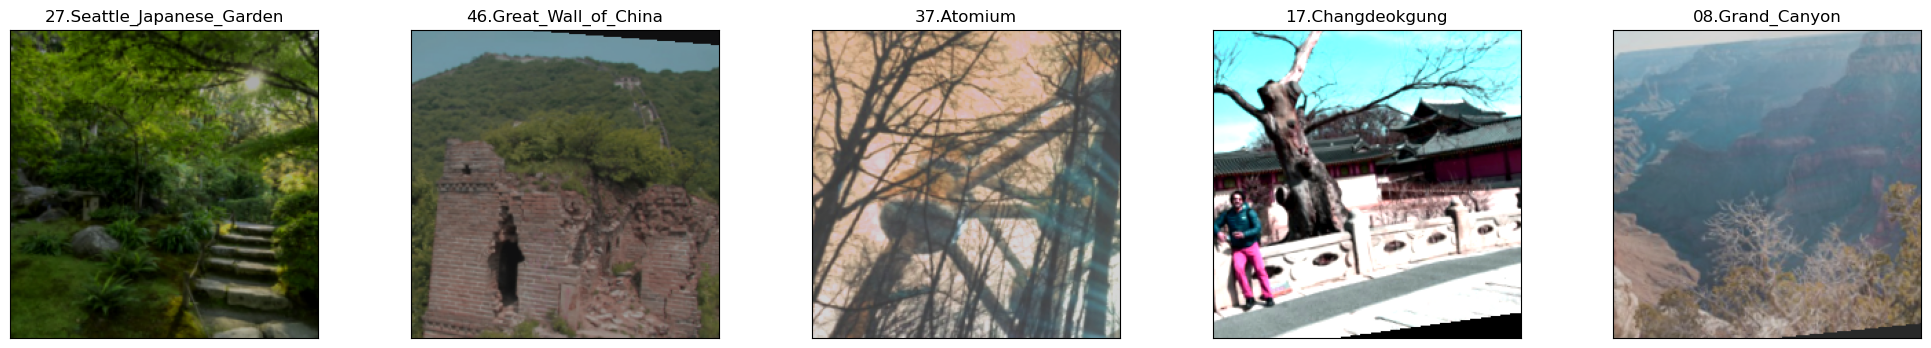

In [7]:
# Visualize a Batch of Training Data
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders
import multiprocessing

data_loaders = get_data_loaders(batch_size=32, valid_size=0.01, num_workers=multiprocessing.cpu_count())

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

Open `src/model.py` and complete the `MyModel` class filling in all the `YOUR CODE HERE` sections. After you're done, execute the following test and make sure it passes:

In [8]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

=============================== warnings summary ===============================
src/model.py::test_model_construction
  /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
    warnings.warn(_create_warning_msg(

-- Docs: https://docs.pytest.o

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ I decided to use 5 convolutional layers so that my model could be sufficiently expressive. I used dropout layers to reduce my model's tendency to overfit the training data. I made my model output a 50-dimensional vector to match with the 50 available landmark classes.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer

Open `src/optimization.py` and complete the `get_loss` function, then execute the test and make sure it passes:

In [9]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 1.40s ========================


Then, in the same file, complete the `get_optimizer` function then execute its tests, and make sure they all pass:

In [10]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decay PASSED         [100%]

======================= 6 passed, 1 deselected in 1.41s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions you are completing, so it will help you catching glaring problems but it won't guarantee that your training code is bug-free. If you see that your loss is not decreasing, for example, that's a sign of a bug or of a flawed model design. Use your judgement.

Open `src/train.py` and complete the `train_one_epoch` function, then run the tests:

In [11]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 14.16s =======================


Now complete the `valid` function, then run the tests:

In [12]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 8.17s ========================


Now complete the `test` function then run the tests:

In [13]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

======================= 1 passed, 3 deselected in 8.18s ========================


Finally, complete the `optimize` function, then run the tests:

In [14]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

======================= 1 passed, 3 deselected in 21.43s =======================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. Feel free to experiment with different values and try to optimize your model:

In [15]:
batch_size = 64
valid_size = 0.2
num_epochs = 65
num_classes = 50
dropout = 0.4
learning_rate = 0.0001
opt = 'adam'
weight_decay = 0.01

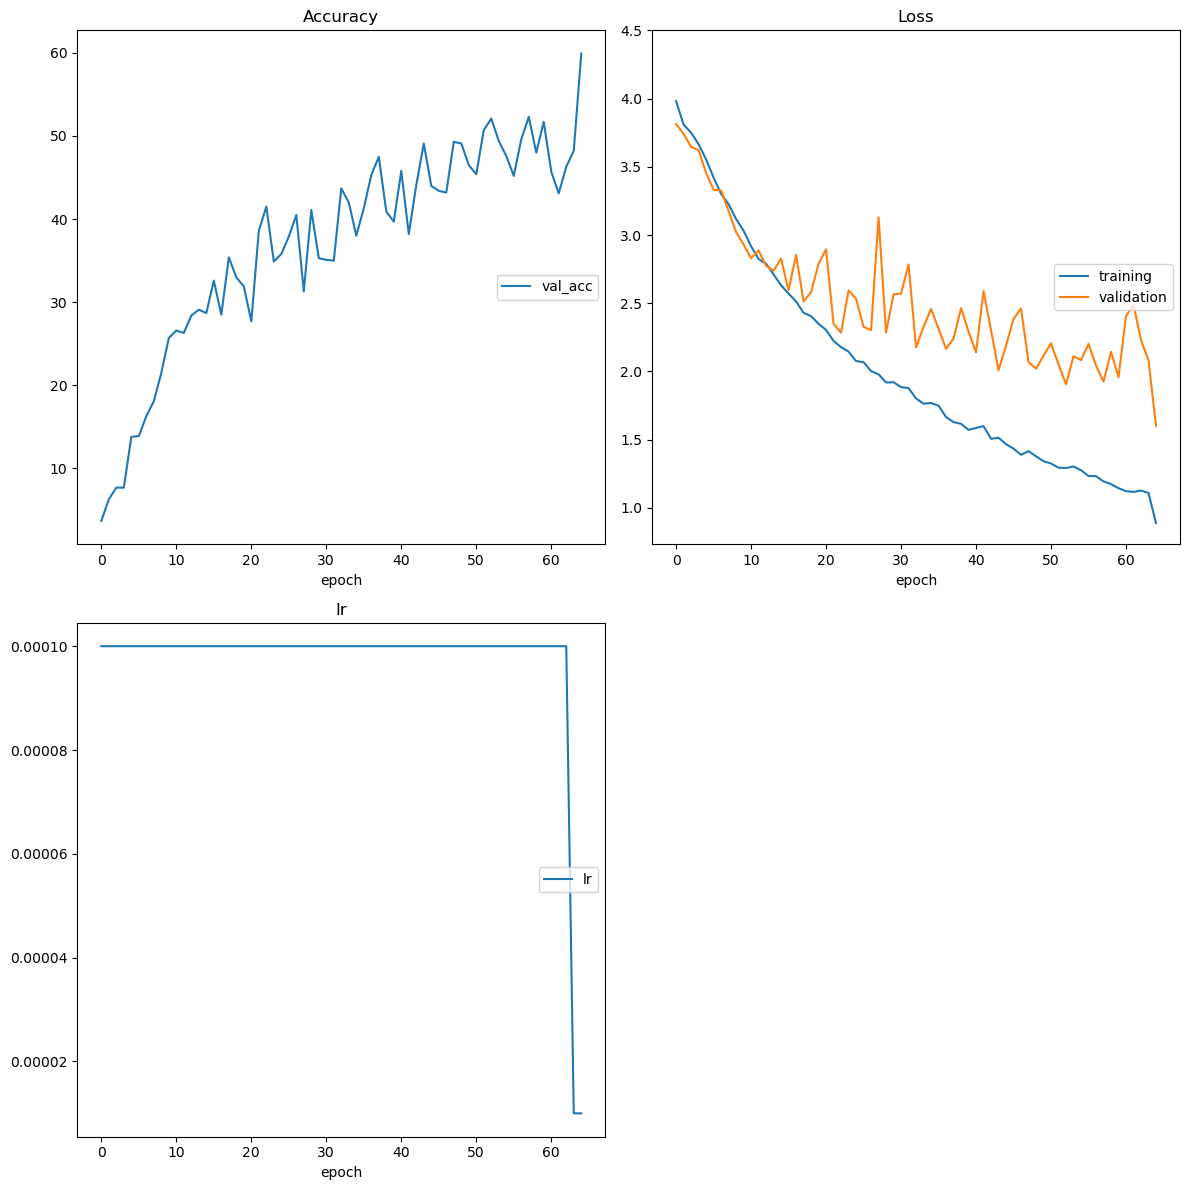

In [16]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel, ResidualBlock
import multiprocessing
import torch

# Get the data loaders using batch_size and valid_size defined in the previous cell
# HINT: do NOT copy/paste the values. Use the variables instead
# You can set the number of workers equal to the CPU count obtained using `multiprocessing.cpu_count()`.
# Get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=multiprocessing.cpu_count())

# Instantiate model MyModel with num_classes and dropout defined in the previous cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Optionally, you can load your previous saved model here

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

# Add learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> only run this *after* you have completed hyperpameter optimization. Do not optimize hyperparameters by looking at the results on the test set, or you might overfit on the test set (bad, bad, bad)

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [17]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# Load the model that got the best validation accuracy
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt"))

# Run test
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]

Test Loss: 1.375516


Test Accuracy: 65% (818/1250)


(1.3755161881446838, tensor(65.4400))

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual, we need to complete some code!

Open `src/predictor.py` and fill up the missing code, then run the tests:

In [18]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

=============================== warnings summary ===============================
src/predictor.py::test_model_construction
  /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
    warnings.warn(_create_warning_msg(

src/predictor.py::test_mod

Allright, now we are ready to export our model using our Predictor class:

In [19]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# Get the class names from the train data loader
class_names = data_loaders["train"].dataset.classes

# Initialize and move the model to CPU
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Load the best model weights
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt", map_location='cpu'))

# Compute mean and std for normalization
mean, std = compute_mean_and_std()

# Wrap the model using the Predictor class
predictor = Predictor(model, class_names, mean, std).cpu()

# Export the model using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/original_exported.pt")

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
Total number of images in train_data: 4996
Number of training images: 3996
Number of validation images: 1000


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [20]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt")

In [21]:
import warnings

In [22]:
from src.predictor import predictor_test

# Ignore warnings during testing
warnings.filterwarnings("ignore")

# Test the reloaded model
pred, truth = predictor_test(data_loaders['test'], model_reloaded)

# Re-enable warnings
warnings.filterwarnings("default")


100%|███████████████████████████████████████| 1250/1250 [01:12<00:00, 17.35it/s]

Accuracy: 0.636


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

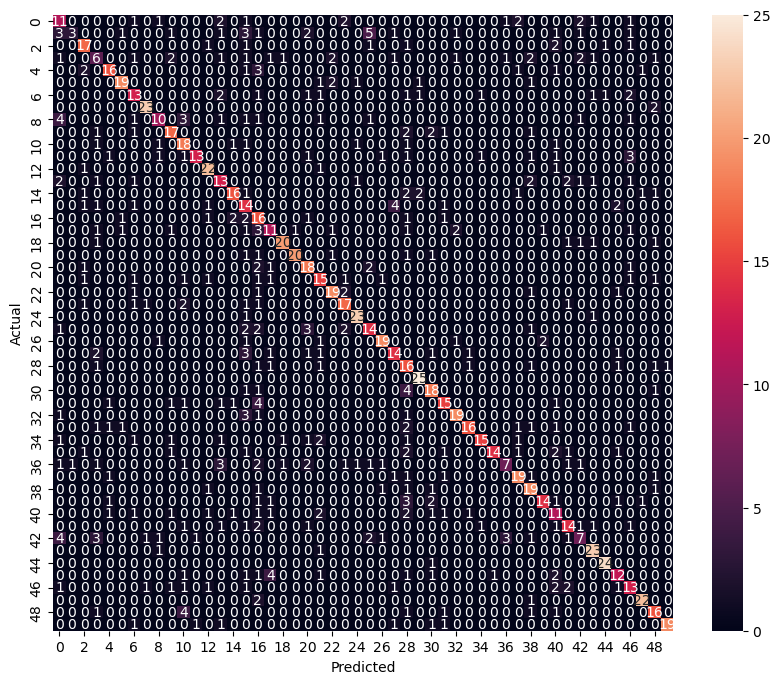

In [23]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)